# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Selection:"

This lecture was one with the most divergence between Python ```statsmodels``` and R.  The standard tools of R for refining a regression model by reducing irrelvant parameters appear not to be matched by functions available from ```statsmodels```.

However, Machine Learning has model refinement as one of its core processes.  This post will cover some of these.

One of the datasets used by the STATS191 course dealth with USA Presidential Election votes, and a number of proposed explanatory parameters (Incumbancy, Economic Growth, etc).  I started out cranking the numbers on this dataset, but then started to have my doubts.  The dataset covered all the 20th century; are we to believe that the fundamental mechanisms that operated to decide political choice in 1912 are the same as in 2000, given the huge demographic and cultural changes in the USA?  Now maybe the answer is "Yes", but that is a large claim that I would want justified, before blindly accepting the results of a statistical model.




## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

In [3]:
%matplotlib inline

### Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from sklearn import linear_model

import seaborn as sns

D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


------
## Model Selection

### Election Dataset

As an example of the issues around selecting the best linear model, we use a datset with attributes as below.



|Variable|	Description|
|---|---|
|V| 	votes for a presidential candidate|
|I| 	are they incumbent?|
|D| 	Democrat or Republican incumbent?|
|W| 	wartime election?|
|G| 	GDP growth rate in election year|
|P| 	(absolute) GDP deflator growth rate|
|N| 	number of quarters in which GDP growth rate  >3.2% |

### Read and Explore Dataset

In [5]:
data = pd.read_csv('../data/election.txt', sep='\t')
data.head()

,Year,V,I,D,W,G,P,N
0,1916,0.5168,1,1,0,2.229,4.252,3
1,1920,0.3612,1,0,1,-11.463,16.535,5
2,1924,0.4176,-1,-1,0,-3.872,5.161,10
3,1928,0.4118,-1,0,0,4.623,0.183,7
4,1932,0.5916,-1,-1,0,-14.901,7.069,4


We look at the unique values for each column

In [6]:
for n in data.columns:
    uniq_val = data[n].unique()
    print(f'Column {n}: {uniq_val}')
# end for

Column Year  : [1916 1920 1924 1928 1932 1936 1940 1944 1948 1952 1956 1960 1964 1968
 1972 1976 1980 1984 1988 1992 1996]
Column V  : [0.5168 0.3612 0.4176 0.4118 0.5916 0.6246 0.55   0.5377 0.5237 0.446
 0.4224 0.5009 0.6134 0.496  0.3821 0.5105 0.447  0.4083 0.461  0.5345
 0.5474]
Column I  : [ 1 -1]
Column D  : [ 1  0 -1]
Column W  : [0 1]
Column G  : [  2.229 -11.463  -3.872   4.623 -14.901  11.921   3.708   4.119   1.849
   0.627  -1.527   0.114   5.054   4.836   6.278   3.663  -3.789   5.387
   2.068   2.293   2.918]
Column P  : [ 4.252 16.535  5.161  0.183  7.069  2.362  0.028  5.678  8.722  2.288
  1.936  1.932  1.247  3.215  4.766  7.657  8.093  5.403  3.272  3.692
  2.268]
Column N  : [ 3  5 10  7  4  9  8 14  6  1]


### Visualization

We can visualize the relationship between columns using Seaborn.  We exclude the first column, as it just holds year of election.

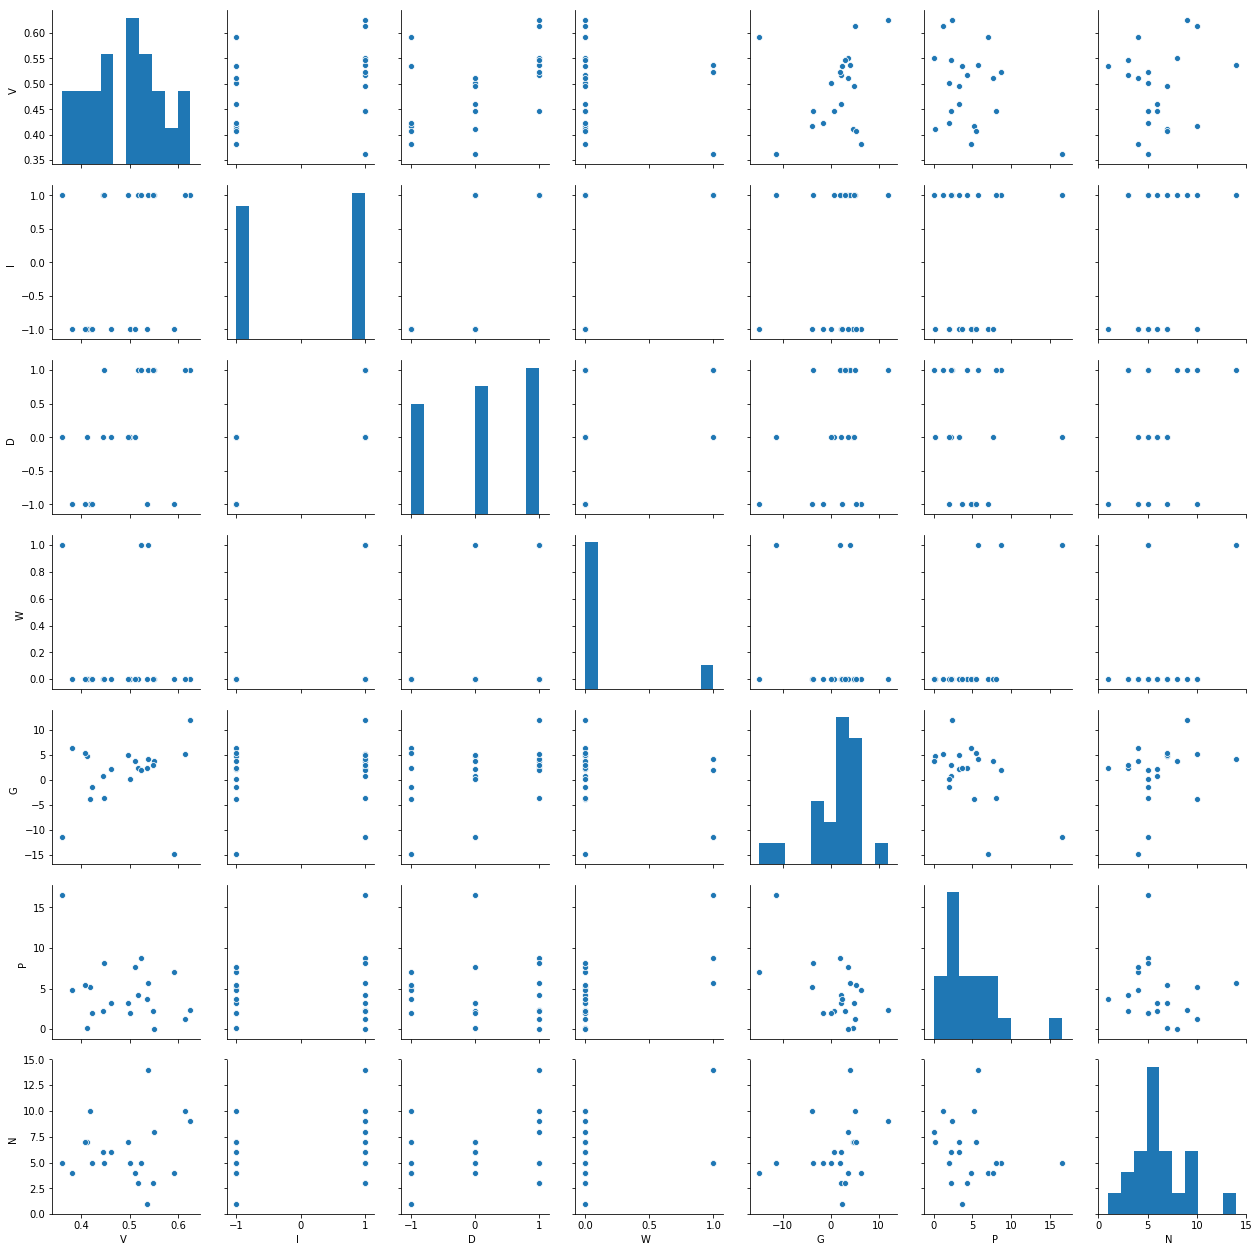

In [7]:
sns.pairplot(data=data[data.columns[1:]])

### Cleaning Dataset

We find some trailing whitespace in column names, so we remove them

In [8]:
_ = [print(f'>{n}<') for n in data.columns]

>Year  <
>V  <
>I  <
>D  <
>W  <
>G  <
>P  <
>N  <


In [9]:
new_names = [n.strip() for n in data.columns]
_ = [print(f'>{n}<') for n in new_names]

>Year<
>V<
>I<
>D<
>W<
>G<
>P<
>N<


In [10]:
data.columns = new_names

-----
## Model Building

As a start in model building, we start by incorporating almost all the possible explanatory parameters, and add in the interaction betwen Incumbency and Economic Growth (rather than Growth on its own).

In [11]:
res0 = ols('V ~ I + D + W + G:I + P + N', data=data).fit()
res0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     8.769
Date:                Tue, 05 May 2020   Prob (F-statistic):           0.000435
Time:                        19:57:23   Log-Likelihood:                 41.470
No. Observations:                  21   AIC:                            -68.94
Df Residuals:                      14   BIC:                            -61.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5112      0.032     15.875      0.000       0.442       0.580
I             -0.0201      0.017     -1.190      0.254      -0.056       0.016
D              0.0546      0.021      2.655      0.019       0.010       0.099
W              0.0134      0.042      0.317      0.756      -0.077       0.104
G:I            0.0097      0.002      5.471      0.000       0.006       0.013
P             -0.0007      0.004     -0.180      0.859      -0.009       0.008
N             -0.0052      0.004     -1.361      0.195      -0.013       0.003
==============================================================================
Omnibus:                        6.714   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                4.488
Skew:                           1.074   Prob(JB):                        0.106
Kurtosis:                       3.719   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A number of the parameters have coefficients with p values that indicate that might be candidates for exclusion from the model


---
### Stepwise Model Building

We next look at each of our proposed parameters, one by one, and look at the variance explained

In [12]:
for variable in ['I', 'D', 'W', 'G:I', 'P', 'N']:
    model = 'V ~ ' + variable
    res1 = ols(model, data=data).fit()
    print(
        f' variable {variable:5} alone has R^2 adj = {res1.rsquared:6.4f}'
    )
# end for

 variable I     alone has R^2 adj = 0.1200
 variable D     alone has R^2 adj = 0.2492
 variable W     alone has R^2 adj = 0.0084
 variable G:I   alone has R^2 adj = 0.6122
 variable P     alone has R^2 adj = 0.1104
 variable N     alone has R^2 adj = 0.0215


We now repeat a process of finding the unused parameter (not already in our evolving model) that most improves our model score (here R^2), and then adding it to our model

In [13]:
# start with empty model
base_model = 'V ~ '
variables_start = ['I', 'D', 'W', 'G:I', 'P', 'N']
#
# variables is the list of as yet unused parameters
#
variables = ['I', 'D', 'W', 'G:I', 'P', 'N']

# as we improve(?) the model, we track the improvement in R^2
model_r2 = []

# run over all unused parameters, find one that when added to the current model, maximizes R^2
for count in range(1, len(variables) + 1):
    max_r2 = -1  #
    for variable in variables:
        model = base_model + ' + ' + variable
        res1 = ols(model, data=data).fit()
        # is this a better model than any seen so far?
        if res1.rsquared > max_r2:
            max_var = variable
            max_r2 = res1.rsquared
        # end if

    # end for
    # update model with one that maximizes R^2
    base_model = base_model + ' + ' + max_var

    print(
        f' model {base_model:30}  has R^2 = {max_r2:6.4f}'
    )
    # update list of unused variables, by removing one just added to model

    variables.remove(max_var)
    model_r2.append(max_r2)

# end for

 model V ~  + G:I                      has R^2 = 0.6122
 model V ~  + G:I + D                  has R^2 = 0.7345
 model V ~  + G:I + D + N              has R^2 = 0.7652
 model V ~  + G:I + D + N + I          has R^2 = 0.7883
 model V ~  + G:I + D + N + I + W      has R^2 = 0.7893
 model V ~  + G:I + D + N + I + W + P  has R^2 = 0.7898


Do a quick and easy plot showimng improvement in R^2

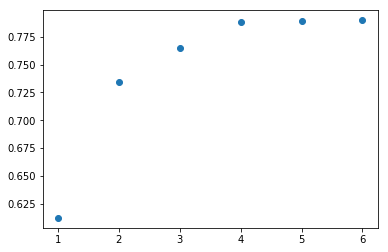

In [14]:
_ = plt.plot(
    list(range(1, len(variables_start) + 1)), model_r2, 'o'
)

---
### Adjusted R^2

Do this all over again, but using an adjusted R^2.  The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance

In [15]:
base_model = 'V ~ '
variables_start = ['I', 'D', 'W', 'G:I', 'P', 'N']
variables = ['I', 'D', 'W', 'G:I', 'P', 'N']

model_r2 = []
for count in range(1, len(variables) + 1):
    max_r2 = float(
        '-inf'
    )  # must be smaller than first r^2 adjusted value
    for variable in variables:
        model = base_model + ' + ' + variable
        res1 = ols(model, data=data).fit()
        if res1.rsquared_adj > max_r2:
            max_var = variable
            max_r2 = res1.rsquared_adj
        # end if

    # end for
    base_model = base_model + ' + ' + max_var

    print(
        f' model {base_model:30}  has R^2 (adjusted) = {max_r2:6.4f}'
    )
    variables.remove(max_var)
    model_r2.append(max_r2)

# end for

 model V ~  + G:I                      has R^2 (adjusted) = 0.5918
 model V ~  + G:I + D                  has R^2 (adjusted) = 0.7050
 model V ~  + G:I + D + N              has R^2 (adjusted) = 0.7238
 model V ~  + G:I + D + N + I          has R^2 (adjusted) = 0.7353
 model V ~  + G:I + D + N + I + W      has R^2 (adjusted) = 0.7191
 model V ~  + G:I + D + N + I + W + P  has R^2 (adjusted) = 0.6998


The adjusted R^2 plot shows that the last two parameters added to the model have made it worse

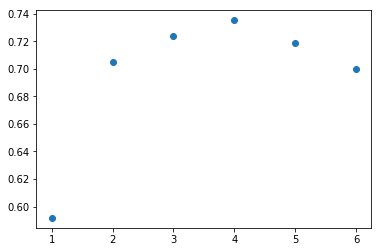

In [16]:
_ = plt.plot(
    list(range(1, len(variables_start) + 1)), model_r2, 'o'
)

---
### AIC as a Model Score

"The Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models."

We repeat the step by step addition of parameters to the model, this time using AIC as our model score

In [17]:
base_model = 'V ~ '
variables_start = ['I', 'D', 'W', 'G:I', 'P', 'N']
variables = ['I', 'D', 'W', 'G:I', 'P', 'N']

model_aic = []
for count in range(1, len(variables) + 1):
    max_aic = float(
        '-inf'
    )  # must be smaller than first aic value
    for variable in variables:
        model = base_model + ' + ' + variable
        res1 = ols(model, data=data).fit()
        if res1.aic > max_aic:
            max_var = variable
            max_aic = res1.aic
            r2_at_max_aic = res1.rsquared
        # end if

    # end for
    base_model = base_model + ' + ' + max_var

    print(
        f' model {base_model:30}  has AIC = {max_aic:6.4f}, R^2 = {r2_at_max_aic:6.4f}'
    )
    variables.remove(max_var)
    model_aic.append(max_aic)

# end for

 model V ~  + W                        has AIC = -46.3619, R^2 = 0.0084
 model V ~  + W + N                    has AIC = -45.0469, R^2 = 0.0403
 model V ~  + W + N + P                has AIC = -45.2760, R^2 = 0.1369
 model V ~  + W + N + P + I            has AIC = -46.5723, R^2 = 0.2623
 model V ~  + W + N + P + I + D        has AIC = -46.9250, R^2 = 0.3405
 model V ~  + W + N + P + I + D + G:I  has AIC = -68.9403, R^2 = 0.7898


The quick and easy plot of AIC scores suggests the the last parameter should definitely by dropped from our model, and that really only the first two parameters should be in the model

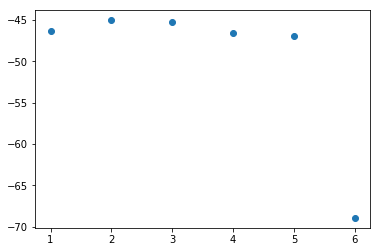

In [18]:
_ = plt.plot(
    list(range(1, len(variables_start) + 1)), model_aic, 'o'
)

-----
### BIC for Model Score

"The Bayesian information criterion (BIC)  is a criterion for model selection among a finite set of models. It is based, in part, on the likelihood function, and it is closely related to Akaike information criterion (AIC). ... The penalty term is larger in BIC than in AIC:"

In [19]:
base_model = 'V ~ '
variables_start = ['I', 'D', 'W', 'G:I', 'P', 'N']
variables = ['I', 'D', 'W', 'G:I', 'P', 'N']

model_bic = []
for count in range(1, len(variables) + 1):
    max_bic = float(
        '-inf'
    )  # must be smaller than first aic value
    for variable in variables:
        model = base_model + ' + ' + variable
        res1 = ols(model, data=data).fit()
        if res1.bic > max_bic:
            max_var = variable
            max_bic = res1.bic
            r2_at_max_bic = res1.rsquared
        # end if

    # end for
    base_model = base_model + ' + ' + max_var

    print(
        f' model {base_model:30}  has AIC = {max_bic:6.4f}, R^2 = {r2_at_max_bic:6.4f}'
    )
    variables.remove(max_var)
    model_bic.append(max_bic)

# end for

 model V ~  + W                        has AIC = -44.2729, R^2 = 0.0084
 model V ~  + W + N                    has AIC = -41.9133, R^2 = 0.0403
 model V ~  + W + N + P                has AIC = -41.0979, R^2 = 0.1369
 model V ~  + W + N + P + I            has AIC = -41.3497, R^2 = 0.2623
 model V ~  + W + N + P + I + D        has AIC = -40.6578, R^2 = 0.3405
 model V ~  + W + N + P + I + D + G:I  has AIC = -61.6286, R^2 = 0.7898


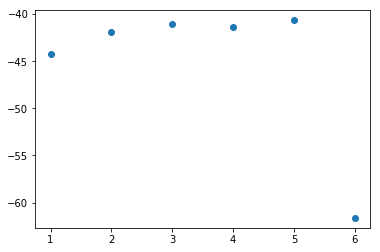

In [20]:
_ = plt.plot(
    list(range(1, len(variables_start) + 1)), model_bic, 'o'
)

 ------
 ## Least Absolute Shrinkage and Selection Operator (LASSO)
 
 We now move to the functions provided by the Machine Learning packages of Python, where a variety of penalties for an excessive numbers of parameters in the models can be accessed (under a variety of opaque abreviations: well, opaque to me, they probably are very familiar to evry-day users).
 
 The key concept is that there is an ```alpha``` value, that measures the penalty applied to irrelevant parameters.
 
 In the code below, we step through a number of ```alpha``` values (```alpha```=0 is equivalent to Ordinary Least Squares regression), and for each ```alpha``` value record the coefficient of each parameter in our model.  The default ```score``` returned is our old friend R^2 

In [21]:
data['GI'] = data['G'] * data['I']

#  set up dict that will hold coefficient list( for the alpha values) for each coefficient
#  initially we have an empty list

var_coefs = {
    n: []
    for n in ['Intercept', 'I', 'D', 'W', 'P', 'N', 'GI']
}

#  scores holds the R^2 value for a model
scores = []

# run over all alpha values
for alpha in [0.00001, 0.0005, 0.001, 0.002, 0.005]:

    # perform regularized regression for this current value of alpha
    reg = linear_model.Lasso(alpha=alpha, normalize=True)
    reg.fit(
        np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
        np.asarray(data['V']),
    )

    # update the coefficient value for each parameter, fot this alpha value
    for n, v in zip(
        data[['I', 'D', 'W', 'P', 'N', 'GI']].columns,
        reg.coef_,
    ):
        var_coefs[n].append(v)
    # end for
    var_coefs['Intercept'].append(reg.intercept_)

    # show the alpha score
    print(f'Score for alpha = {alpha}')
    print(
        reg.score(
            np.asarray(
                data[['I', 'D', 'W', 'P', 'N', 'GI']]
            ),
            np.asarray(data['V']),
        )
    )
    # append this score to list of scores
    scores.append(
        reg.score(
            np.asarray(
                data[['I', 'D', 'W', 'P', 'N', 'GI']]
            ),
            np.asarray(data['V']),
        )
    )
# end for

Score for alpha = 1e-05
0.7898183343142353
Score for alpha = 0.0005
0.7742464846315218
Score for alpha = 0.001
0.7488693170370382
Score for alpha = 0.002
0.708415913993653
Score for alpha = 0.005
0.5714516999832228


Do a quick plot.  It appears that ```alpha``` = 0.002 removes most of the irrelevant parameters (by setting there coefficient to 0)

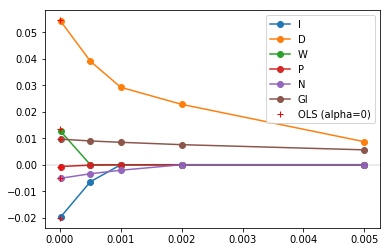

In [22]:
alphas = [0.00001, 0.0005, 0.001, 0.002, 0.005]
for n in ['I', 'D', 'W', 'P', 'N', 'GI']:
    _ = plt.plot(alphas, var_coefs[n], '-o', label=n)
# end for
for x in res0.params[1:]:
    _ = plt.plot(0, x, 'r+')
# end for
_ = plt.plot(0, x, 'r+', label='OLS (alpha=0)')
_ = plt.axhline(0, color='k', alpha=0.1)
_ = plt.legend(loc='best')

Do a more detailed  plot, showing score with parameter coefficient values

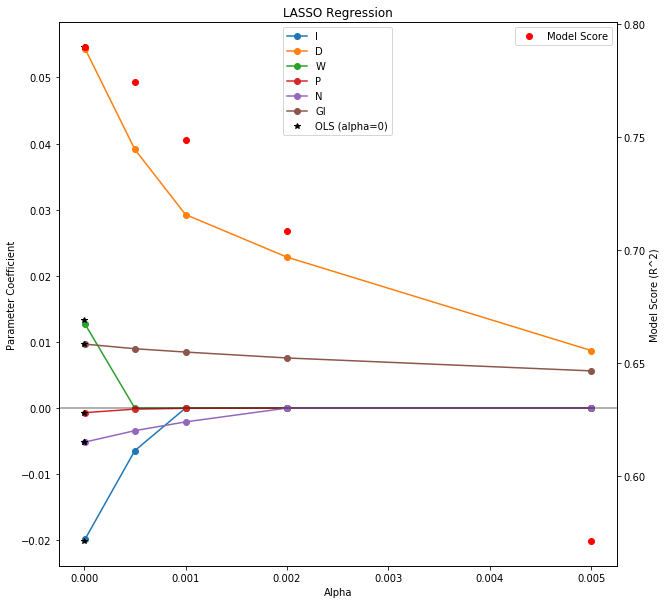

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))


for n in ['I', 'D', 'W', 'P', 'N', 'GI']:
    _ = ax.plot(alphas, var_coefs[n], '-o', label=n)
# end for

# show the original OLS values
for x in res0.params[1:]:
    _ = ax.plot(0, x, 'k*')
# end for
_ = ax.plot(0, x, 'k*', label='OLS (alpha=0)')
_ = ax.axhline(0, color='k', alpha=0.4)
_ = ax.legend(loc='upper center')
ax.set_ylabel('Parameter Coefficient')
ax.set_xlabel('Alpha')
ax.set_title('LASSO Regression')

ax2 = ax.twinx()
ax2.plot(alphas, scores, 'ro', label='Model Score')
ax2.set_ylabel('Model Score (R^2)')
ax2.legend(loc='upper right')

----
### Ridge Regression

Ridge Regression is another way of penalizing a model with irrelevant parameters.

In [24]:
data['GI'] = data['G'] * data['I']

var_coefs = {
    n: []
    for n in ['Intercept', 'I', 'D', 'W', 'P', 'N', 'GI']
}

scores = []
alphas = [0.00001, 0.005, 0.01, 0.1, 0.5, 1, 2, 10]

for alpha in alphas:
    reg = linear_model.Ridge(alpha=alpha, normalize=True)
    reg.fit(
        np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
        np.asarray(data['V']),
    )

    for n, v in zip(
        data[['I', 'D', 'W', 'P', 'N', 'GI']].columns,
        reg.coef_,
    ):
        var_coefs[n].append(v)
    # end for
    var_coefs['Intercept'].append(reg.intercept_)

    print(f'Score for alpha = {alpha}')
    print(
        reg.score(
            np.asarray(
                data[['I', 'D', 'W', 'P', 'N', 'GI']]
            ),
            np.asarray(data['V']),
        )
    )
    scores.append(
        reg.score(
            np.asarray(
                data[['I', 'D', 'W', 'P', 'N', 'GI']]
            ),
            np.asarray(data['V']),
        )
    )
# end for

Score for alpha = 1e-05
0.7898281695208687
Score for alpha = 0.005
0.7897406174277011
Score for alpha = 0.01
0.7894952699571175
Score for alpha = 0.1
0.7730490922927719
Score for alpha = 0.5
0.6808871096904584
Score for alpha = 1
0.5919662256810726
Score for alpha = 2
0.4697432944513993
Score for alpha = 10
0.17618984128864557


The plot indicates that the ```N``` parameter probably should be dropped from the model.

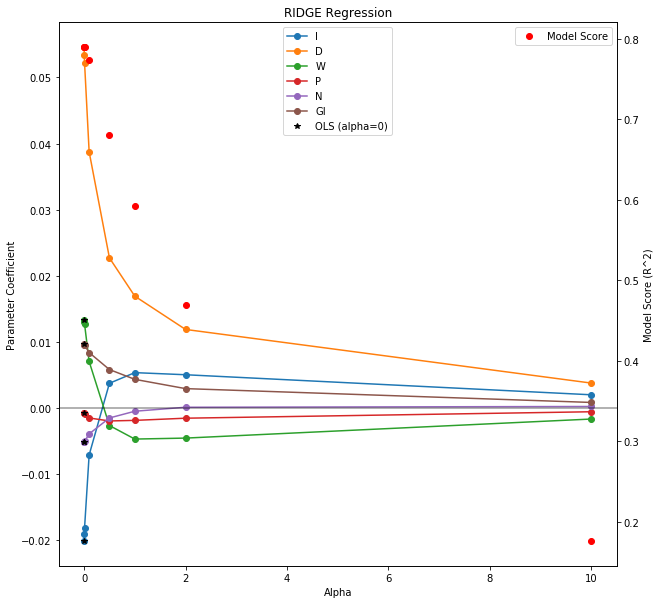

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))


for n in ['I', 'D', 'W', 'P', 'N', 'GI']:
    _ = ax.plot(alphas, var_coefs[n], '-o', label=n)
# end for
for x in res0.params[1:]:
    _ = ax.plot(0, x, 'k*')
# end for
_ = ax.plot(0, x, 'k*', label='OLS (alpha=0)')
_ = ax.axhline(0, color='k', alpha=0.4)
_ = ax.legend(loc='upper center')
ax.set_ylabel('Parameter Coefficient')
ax.set_xlabel('Alpha')
ax.set_title('RIDGE Regression')

ax2 = ax.twinx()
ax2.plot(alphas, scores, 'ro', label='Model Score')
ax2.set_ylabel('Model Score (R^2)')
ax2.legend(loc='upper right')

----
## LASSO with Cross Validation 

One problem with penalizing bad paramters (as measured by ```alpha```) is: what value of ```alpha``` should I use?  The Cross Validation process build a model from  a subset of the dataset, and score the model by looking at the prediction error of the model when applied the remaining subset.  We vary ```alpha``` till we get a minimum error on the validation dataset

In [26]:
reg = linear_model.LassoCV(normalize=True, cv=5)
reg.fit(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
score = reg.score(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
print(score)

0.7074044689513146


In [27]:
all_coef = [reg.intercept_] + list(reg.coef_)
all_names = ['Intercept'] + ['I', 'D', 'W', 'P', 'N', 'GI']
_ = [
    print(f"{n:15} = {v: 6.4f}")
    for n, v in zip(all_names, all_coef)
]

Intercept       =  0.4821
I               =  0.0000
D               =  0.0226
W               = -0.0000
P               = -0.0000
N               = -0.0000
GI              =  0.0076


In [28]:
reg.alpha_

0.002038401170872668

From the average of the error score across repeated subsetting of the original dataset into model-building and validation subsets, we get a minumum at about ```alpha``` = 0.002

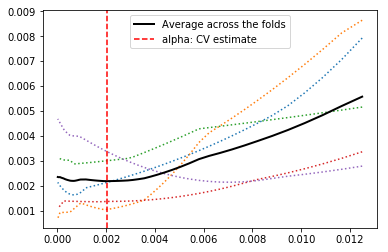

In [29]:
_ = plt.plot(reg.alphas_, reg.mse_path_, ':', alpha=1)
_ = plt.plot(
    reg.alphas_,
    reg.mse_path_.mean(axis=-1),
    'k',
    label='Average across the folds',
    linewidth=2,
)
_ = plt.axvline(
    reg.alpha_,
    linestyle='--',
    color='r',
    label='alpha: CV estimate',
)
plt.legend(loc='best')


-----
## LASSO and Information Criteria

We can score the model in different ways, and below we use the AIC and BIC scores, that  give roughly the same value of ```alpha```.  I am a little suspicious of the results, as it shows AIC- and BIC-scoring to have the same minimum?

The results are to retain the Intercept, ```D```, and ```GI``` (G and I interactio)n parameters in our model, and discard the rest.

In [30]:
reg_bic = linear_model.LassoLarsIC(
    normalize=True, criterion='bic'
)
reg_bic.fit(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
score = reg_bic.score(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
print(f'BIC as criterion, score = {score}')

reg_aic = linear_model.LassoLarsIC(
    normalize=True, criterion='aic'
)
reg_aic.fit(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
score = reg_aic.score(
    np.asarray(data[['I', 'D', 'W', 'P', 'N', 'GI']]),
    np.asarray(data['V']),
)
print(f'AIC as criterion, score = {score}')

BIC as criterion, score = 0.7143878277799238
AIC as criterion, score = 0.7143878277799238


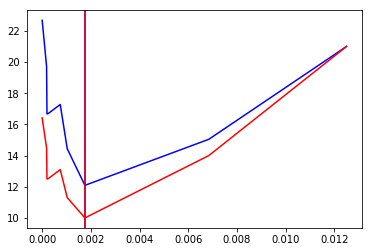

In [31]:
_ = plt.plot(reg_bic.alphas_, reg_bic.criterion_, 'b-')
_ = plt.axvline(reg_bic.alpha_, color='b')

_ = plt.plot(reg_aic.alphas_, reg_aic.criterion_, 'r-')
_ = plt.axvline(reg_aic.alpha_, color='r')

In [32]:
all_coef = [reg_aic.intercept_] + list(reg_aic.coef_)
all_names = ['Intercept'] + ['I', 'D', 'W', 'P', 'N', 'GI']
_ = [
    print(f"{n:15} = {v: 6.4f}")
    for n, v in zip(all_names, all_coef)
]

Intercept       =  0.4818
I               =  0.0000
D               =  0.0240
W               =  0.0000
P               =  0.0000
N               =  0.0000
GI              =  0.0077


In [33]:
all_coef = [reg_bic.intercept_] + list(reg_bic.coef_)
all_names = ['Intercept'] + ['I', 'D', 'W', 'P', 'N', 'GI']
_ = [
    print(f"{n:15} = {v: 6.4f}")
    for n, v in zip(all_names, all_coef)
]

Intercept       =  0.4818
I               =  0.0000
D               =  0.0240
W               =  0.0000
P               =  0.0000
N               =  0.0000
GI              =  0.0077


-----
## Environment

In [34]:
%watermark -h -iv
%watermark

scipy       1.1.0
matplotlib  3.0.2
pandas      1.0.0
sklearn     0.20.1
statsmodels 0.9.0
numpy       1.15.4
seaborn     0.9.0
host name: DESKTOP-SODFUN6
2020-05-05T19:57:29+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [35]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 3.7.1.final.0

Statsmodels

Installed: 0.9.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\Cython)
numpy: 1.15.4 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\numpy)
scipy: 1.1.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy)
pandas: 1.0.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\pandas)
    dateutil: 2.7.5 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\dateutil)
patsy: 0.5.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\joblib)

Developer Tools

IPython: 7.2.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython)
    jinja2: 2.10.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\jinja2)
sphinx: